# Asian restaurant location recommendation in the city of Nur-Sultan (Astana)

In [1]:
import pandas as pd
import geocoder
import folium
from pandas import DataFrame
import json # library to handle JSON files
from geopy.geocoders import Nominatim
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# type your answer here
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

We can obtain the longitude and latitude information of the Nur-Sultan using geopy library

Nur-Sultan city has 4 different postal codes, but only two of them returns different latitude and longitude values, we will use both of them to find restaurants in that area

In [12]:
address = 'Nur-Sultan'
#latitude = []
#longitude = []
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Nur-Sultan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Nur-Sultan are 51.1282205, 71.4306682.


Let's define functions that we will use in order to convert from latitude and longitude coordinate system to Cartesian coordinate system and back. For that purpose pyproj will be used. The conversion is required in order to calculate the Euclidean distances between two locations in 2D Cartesian system using calc_xy_distance function.

In [3]:
#!pip install shapely
import shapely.geometry
import warnings
warnings.filterwarnings('ignore')
#!pip install pyproj
from pyproj import Transformer
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    #transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
    #xy = Transformer.transform(proj_xy, lon, lat)
    
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    #transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
    #lonlat = Transformer.transform(proj_latlon, x, y)
    
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Nur-Sultan center longitude={}, latitude={}'.format(longitude, latitude))
x, y = lonlat_to_xy(longitude, latitude)
print('Nur-Sultan center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Nur-Sultan center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Nur-Sultan center longitude=71.4306682, latitude=51.1282205
Nur-Sultan center UTM X=4207300.883620112, Y=7320292.069925449
Nur-Sultan center longitude=71.4306682, latitude=51.12822049999999


We will show the map of Nur-Sultan using Folium

In order to increase the number of venues we will have to increase the number of locations. I have identified that the latitude of Nur-Sultan ranges from 51.07 to 51.22, whereas longitude ranges from 71.366 to 71.54. We will add all the latitude and longitude combintaions with two for loop in order to cover as much area as possible. 

In [51]:
latitudes = []
longitudes = []
lat = 0.0
lon = 0.0
for lat in np.arange(51.07, 51.22, 0.01):
    for lon in np.arange(71.366, 71.54, 0.01):
        latitudes.append(lat)
        longitudes.append(lon)
        
print('Total {} locations'.format(len(latitudes)))

Total 270 locations


In [5]:
# create map of Nur-Sultan using latitude and longitude values
nursultan_map = folium.Map(location=[latitude, longitude], zoom_start=11) 
folium.Marker(location=[latitude, longitude], popup='Alexanderplatz').add_to(nursultan_map)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=500, color='blue', fill=False).add_to(nursultan_map)
    #folium.Marker([lat, lon]).add_to(map_berlin)
nursultan_map

Defining Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'NSEPJ0DCEXNEXNUCOLFLMSKN2VQ3VVHHFYXCHC3SJX5EIHWT' # your Foursquare ID
CLIENT_SECRET = 'JJGYI1MSPCYJ1HXMUV1EKVWLOLHD1E2IVPQCZ1PKZRNHSJC3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
ACCESS_TOKEN = 'ZMCAVQIXKUTJ5PUC1ZYWP4EC2GMSLQPCSZLKC4LGZXUQFAW0' # your FourSquare Access Token

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NSEPJ0DCEXNEXNUCOLFLMSKN2VQ3VVHHFYXCHC3SJX5EIHWT
CLIENT_SECRET:JJGYI1MSPCYJ1HXMUV1EKVWLOLHD1E2IVPQCZ1PKZRNHSJC3


The Foursquare API can return only 100 venues per request, therefore by increasing the number of locations within the city of Nur-Sultan we were able to find 505 unique venues within the city as compared to around 125 when only two locational coordinates were used.

In [19]:
radius = 700
LIMIT = 100

venues_list=[]

for i in range(len(latitudes)):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitudes[i], 
        longitudes[i], 
        radius, 
        LIMIT)
    # make the GET request
    #print(requests.get(url).json())
    if 'groups' in requests.get(url).json()["response"]:
        results = requests.get(url).json()["response"]["groups"][0]['items']
    if requests.get(url).json()["response"]["totalResults"] > 0:
        # return only relevant information for each nearby venue
        venues_list.append([(
            latitudes[i], 
            longitudes[i], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = [
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']

nearby_venues

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,51.07,71.386,Nomads Restaurant,51.067540,71.385736,Restaurant
1,51.07,71.386,Ипподром «Казанат» / Kazanat Hippodrome,51.066573,71.386053,Stables
2,51.07,71.386,кольцевая на Astana Airport,51.070365,71.395808,Intersection
3,51.07,71.396,кольцевая на Astana Airport,51.070365,71.395808,Intersection
4,51.07,71.396,"Монумент ""Звезда Астаны""",51.067123,71.395885,Outdoor Sculpture
...,...,...,...,...,...,...
1542,51.21,71.376,hardees,51.204940,71.378679,Bistro
1543,51.21,71.386,Kazakistan,51.208187,71.389590,Airport
1544,51.21,71.396,Kazakistan,51.208187,71.389590,Airport
1545,51.21,71.466,Мега Игрушка,51.206018,71.465088,Toy / Game Store


## Data cleaning

Our requests returned 1173 venues, however there are lots of duplicates as ther is an overlap between two locational coordinates. Since the latitude values are unique for each of the venues, we will drop venues which have similar venue latitude.

In [20]:
nearby_venues.drop_duplicates('Venue Latitude', inplace = True)
nearby_venues.reset_index(inplace=True)
nearby_venues

,index,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,51.07,71.386,Nomads Restaurant,51.067540,71.385736,Restaurant
1,1,51.07,71.386,Ипподром «Казанат» / Kazanat Hippodrome,51.066573,71.386053,Stables
2,2,51.07,71.386,кольцевая на Astana Airport,51.070365,71.395808,Intersection
3,4,51.07,71.396,"Монумент ""Звезда Астаны""",51.067123,71.395885,Outdoor Sculpture
4,5,51.07,71.396,ипподром «Казанат»,51.074657,71.398567,Stables
...,...,...,...,...,...,...,...
861,1537,51.20,71.486,Шарын,51.204158,71.486730,Flea Market
862,1538,51.20,71.486,Береке,51.203643,71.488552,Convenience Store
863,1539,51.20,71.486,Шанхай (базар),51.202403,71.485377,Miscellaneous Shop
864,1542,51.21,71.376,hardees,51.204940,71.378679,Bistro


After dropping duplicates we have 658 unique venues, but it includes all types of venues. Let's print all unique venue categories:

In [21]:
nearby_venues['Venue Category'].unique()

array(['Restaurant', 'Stables', 'Intersection', 'Outdoor Sculpture',
       'Construction & Landscaping', 'New American Restaurant', 'Café',
       'Sculpture Garden', 'Hotel', 'Record Shop',
       'Furniture / Home Store', 'Cafeteria', 'Coffee Shop',
       'Supermarket', 'Sandwich Place', 'Shopping Mall', 'Movie Theater',
       'Seafood Restaurant', 'BBQ Joint', 'Korean Restaurant',
       'Irish Pub', 'Fast Food Restaurant', 'Asian Restaurant',
       'Clothing Store', 'Japanese Restaurant', 'Pelmeni House',
       'Turkish Restaurant', 'Convenience Store', 'Science Museum',
       'Theme Park', 'Bar', 'Baby Store', 'Pastry Shop', 'Pharmacy',
       'Boarding House', 'Skating Rink', 'Gym / Fitness Center',
       'Photography Studio', 'Theater', 'Botanical Garden',
       'Pedestrian Plaza', 'Pub', 'Gun Range', 'Park', 'Hockey Arena',
       'Soccer Stadium', 'Stadium', 'Chinese Restaurant', 'Burger Joint',
       'Concert Hall', 'Health & Beauty Service', 'Department Store',
    

Since we are interested only in restaurants we will create a list that includes only categories which are related to dining and leave venues category of which are in that list. After that we can see that there are 258 restaurants left in the city

In [22]:
restaurant = ['Café', 'Eastern European Restaurant', 'Comfort Food Restaurant', 'Pizza Place', 'Restaurant', 'Hotel Bar', 'Coffee Shop', 'Mediterranean Restaurant',
'Asian Restaurant', 'Italian Restaurant', 'Sushi Restaurant', 'Creperie', 'Korean Restaurant', 'Steakhouse', 'Wine Bar', 'Modern European Restaurant', 
'Chinese Restaurant', 'Burger Joint','Dessert Shop', 'Bakery', 'Gastropub', 'BBQ Joint', 'Caucasian Restaurant', 'Burrito Place','Hookah Bar',
'German Restaurant', 'Halal Restaurant', 'Turkish Restaurant', 'Food', 'Brazilian Restaurant', 'Fast Food Restaurant', 'Middle Eastern Restaurant', 
'Seafood Restaurant', 'Irish Pub', 'Sandwich Place', 'New American Restaurant', 'Cocktail Bar', 'American Restaurant', 'Japanese Restaurant', 
'Argentinian Restaurant', 'Snack Place', 'English Restaurant', 'Wings Joint', 'Sports Bar', 'Diner','Noodle House', 'Beer Bar', 'Breakfast Spot', 'Pub',
'Bar', 'Cafeteria', 'Bistro', 'Tea Room', 'Pelmeni House']

restaurants = nearby_venues.loc[nearby_venues['Venue Category'].isin(restaurant)]
restaurants.reset_index(inplace = True, drop=True)

restaurants.shape

(442, 7)

In [60]:
#restaurants.drop(['index'], axis=1, inplace=True)
restaurants

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,51.07,71.386,Nomads Restaurant,51.067540,71.385736,Restaurant
1,51.07,71.406,Underground Sport Bar,51.064540,71.409202,New American Restaurant
2,51.08,71.386,Cafeteria NU,51.078754,71.393878,Café
3,51.08,71.406,Столовая Expo 2017 Astana,51.077414,71.413949,Cafeteria
4,51.09,71.396,Starbucks,51.089568,71.404154,Coffee Shop
...,...,...,...,...,...,...
437,51.20,71.406,перрон,51.194940,71.409684,Bistro
438,51.20,71.406,Замира,51.204061,71.412133,Bistro
439,51.20,71.406,Coffee room/Astana Train Station,51.194523,71.408830,Coffee Shop
440,51.20,71.466,Смак,51.201302,71.469566,Bistro


## Exploratory data analysis

Let's explore the final list of the restaurants in order to see the frequency of Asian restaurants, their spread around city using Heatmap and distance to Asian restaurants from every locations within city. Also, we will try to find locations suitable for the Asian restaurant. Our recommendation will be based on the foot traffic and competition with other asian restaurants. So, the places where other restaurants are present but no Asian restaurant within 250 m radius.

<AxesSubplot:>

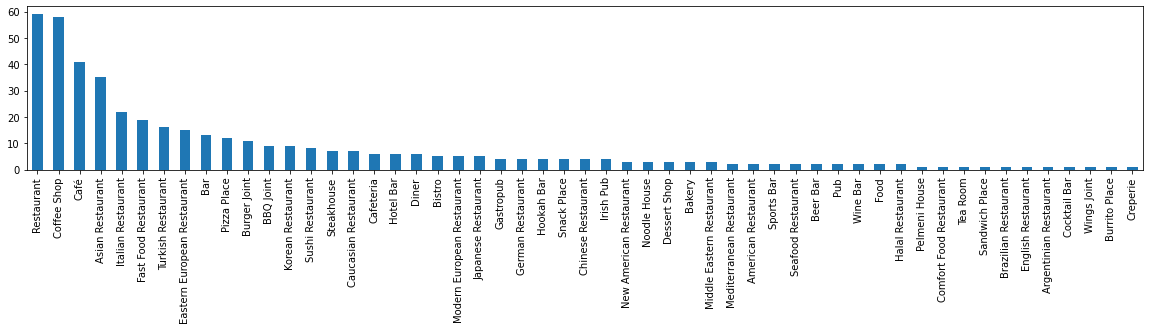

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
restaurants['Venue Category'].value_counts().plot(ax=ax, kind='bar', figsize=(20,3))

From the above plot it can be observed that coffee shops and Asian restaurants are one of the most popular venues in the city. Asian restaurants are in the top 4 of the most popular categories.

We will calculate the general statistical information. There is an special category for the Asian restaurants, but location of other asian category such as sushi restaurant might create a competition. Therefore, Chinese, sushi and Japanese restaurants were also added to the asian categories list. In general, 442 food venues were returned by the Foursquare API in the defined area, 52 (11.76%) of which are Asian restaurants. 

In [25]:
counts = restaurants.groupby('Venue Category').count()
#Count overall number of Asian restaurants by including Asian, Chinese, Sushi and Japanese restaurants
all_asian = counts.loc['Asian Restaurant'][0] + counts.loc['Chinese Restaurant'][0] + counts.loc['Sushi Restaurant'][0] + counts.loc['Japanese Restaurant'][0]

#print general statistics on the the number of all and only Asian restaurants and percentage of Asian restaurants
print('Total number of restaurants:', len(restaurants))
print('Total number of Asian restaurants:', all_asian)
print('Percentage of Asian restaurants: {:.2f}%'.format(all_asian / len(restaurants) * 100))

Total number of restaurants: 442
Total number of Asian restaurants: 52
Percentage of Asian restaurants: 11.76%


The latitude and longitude values of Asian restaurants and all restaurants will be separated to different array for simplifying further visualization on a Folium map

In [26]:
asian_category = ['Asian Restaurant', 'Chinese Restaurant', 'Sushi Restaurant', 'Japanese Restaurant']
restaurant_latlons = []
asian_latlons = []
#Iterate through all restaurants
for index, res in restaurants.iterrows():
    restaurant_latlons.append([res.loc['Venue Latitude'], res.loc['Venue Longitude']]) #append latitude and longitude values to the restaurant_latlons array
    if res.loc['Venue Category'] in asian_category: # check if restaurant is Asian
        asian_latlons.append([res.loc['Venue Latitude'], res.loc['Venue Longitude']]) #append latitude and longitude values to the asian_latlons array

We will visualize all restaurants on Folium map. Asian restaurants will be shown with blue color and other restaurants with red color.

In [65]:
# create map
map_nursultan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, category in zip(restaurants['Venue Latitude'], restaurants['Venue Longitude'], restaurants['Venue'], restaurants['Venue Category']):
    if category in asian_category:
        label = folium.Popup(str(poi), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7).add_to(map_nursultan)
    else:
        label = folium.Popup(str(poi), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7).add_to(map_nursultan)
map_nursultan

Let's visualize the heatmap of restaurants in Nur-Sultan city with circles with radius 1/3/5 km radius, to get insights about the density of restaurants around the city.

In [46]:
from folium import plugins
from folium.plugins import HeatMap

map_nursultan = folium.Map(location=[latitude, longitude], zoom_start=12)
HeatMap(restaurant_latlons).add_to(map_nursultan)
folium.Marker([latitude, longitude]).add_to(map_nursultan)
folium.Circle([latitude, longitude], radius=1000, fill=False, color='white').add_to(map_nursultan)
folium.Circle([latitude, longitude], radius=3000, fill=False, color='white').add_to(map_nursultan)
folium.Circle([latitude, longitude], radius=5000, fill=False, color='white').add_to(map_nursultan)
map_nursultan

From visualization of the heatmap of all restaurants on the Nur-Sultan map, it can be observed that restaurants are densely located in the areas that are popular among tourists. Namely this locations are around Nurly-zhol, Expo, Botanical garden, Prezidential Park and Naberezhnaya.

In [63]:
from folium import plugins
from folium.plugins import HeatMap

map_nursultan = folium.Map(location=[latitude, longitude], zoom_start=12)
HeatMap(asian_latlons).add_to(map_nursultan)
folium.Marker([latitude, longitude]).add_to(map_nursultan)
folium.Circle([latitude, longitude], radius=1000, fill=False, color='white').add_to(map_nursultan)
folium.Circle([latitude, longitude], radius=3000, fill=False, color='white').add_to(map_nursultan)
folium.Circle([latitude, longitude], radius=5000, fill=False, color='white').add_to(map_nursultan)
map_nursultan

For each 270 locations around the city we will calculate the number of the restaurants within the radius of the 400 meters and the distance to the nearest Asian restaurant

In [52]:
distances_to_asian = [0]*len(latitudes)
count_res = [0]*len(latitudes)

#Iterate through all 223 locations within Nur-Sultan city
for i in range(len(latitudes)):
    count = 0
    xn, yn = lonlat_to_xy(longitudes[i], latitudes[i]) #convert longitude and latitude to cartesian xy coordinates
    for j in range(len(restaurant_latlons)): #iterate through all restaurants
        xr, yr = lonlat_to_xy(restaurant_latlons[j][1], restaurant_latlons[j][0])
        if calc_xy_distance(xn, yn, xr, yr) < 400: #check if the restaurant is within 400 m from location
            count += 1
    count_res[i] = count #store # of restaurants within 400 m
    
    dmin = 100000
    for k in range(len(asian_latlons)): #iterate through all asian restaurants
        xa, ya = lonlat_to_xy(asian_latlons[k][1], asian_latlons[k][0]) #convert longitude and latitude to cartesian xy coordinates
        d = calc_xy_distance(xn, yn, xa, ya) #calculate distance to asian restaurant
        if d < dmin:
            dmin = d
    distances_to_asian[i] = dmin #store the distance to the nearest asian restaurant

We will convert it to the pandas dataframe and we can see the final dataframe

In [54]:
locations_summary = pd.DataFrame({'Latitude':latitudes,
                                 'Longitude':longitudes,
                                 'Restaurants count':count_res,
                                 'Nearest Asian restaurant':distances_to_asian})

locations_summary.head()

,Latitude,Longitude,Restaurants count,Nearest Asian restaurant
0,51.07,71.366,0,4247.901919
1,51.07,71.376,0,3597.873127
2,51.07,71.386,1,3032.405950
3,51.07,71.396,0,2607.150116
4,51.07,71.406,0,2397.937705


In [55]:
good_res_count = np.array((locations_summary['Restaurants count']>=2))
print('Locations with no more than two restaurants nearby:', good_res_count.sum())

good_ita_distance = np.array(locations_summary['Nearest Asian restaurant']>=400)
print('Locations with no Asian restaurants within 400 m:', good_ita_distance.sum())

good_locations = np.logical_and(good_res_count, good_ita_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = locations_summary[good_locations]

Locations with no more than two restaurants nearby: 33
Locations with no Asian restaurants within 400 m: 257
Locations with both conditions met: 22


We will choose locations that have more than two restaurants within the radius of 400 meters, because places that have restaurants nearby is popular among tourists and have high food traffic. Also, we will choose places that do not have Asian restaurant closer than 400 m. There are 29 that satisfy this two conditions. Let's visualize these 29 locations on a Folium map with the heatmap of the restaurants

In [56]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

nursultan_map = folium.Map(location=[latitude, longitude], zoom_start=14)
HeatMap(restaurant_latlons).add_to(nursultan_map)
folium.Circle([latitude, longitude], radius=00, color='white', fill=True, fill_opacity=0.6).add_to(nursultan_map)
folium.Marker([latitude, longitude]).add_to(nursultan_map)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(nursultan_map) 
nursultan_map

## Clustering

Now we will cluster all 29 locations into 8 clusters in order to group locations in one area into one locations that averages all locations into one

In [67]:
# set number of clusters
kclusters = 5
xys = []
for i in range(len(good_locations)):
    x, y = lonlat_to_xy(good_locations[i][1], good_locations[i][0])
    xys.append([x, y])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

nursultan_map = folium.Map(location=[latitude, longitude], zoom_start=14)
HeatMap(restaurant_latlons).add_to(nursultan_map)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(nursultan_map) 
    folium.Marker([lat, lon]).add_to(nursultan_map)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(nursultan_map)
nursultan_map